<a href="https://colab.research.google.com/github/AnupriyaRathaur/CDAC-Final-Project/blob/main/ANPR_System_Using_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

STEP 0: ENVIRONMENT SETUP (CPU / GPU)

In [ ]:
# Check GPU
import torch
print("CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

CUDA Available: True
GPU: Tesla T4


In [ ]:
# Install required libraries
!pip install ultralytics opencv-python easyocr matplotlib kaggle tqdm pillow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 105.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.2/978.2 kB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 26.9 MB/s eta 0:00:00


STEP 1: DATASET COLLECTION (KAGGLE)

In [ ]:
# Upload kaggle.json
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{\r\n  "username": "deepshikhatyagi",\r\n  "key": "KGAT_31078f5c5ee7f62babbdd4a7e17ed509"\r\n}\r\n'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
# Download dataset
!kaggle datasets download -d andrewmvd/car-plate-detection
!unzip car-plate-detection.zip -d plate_data


Dataset URL: https://www.kaggle.com/datasets/andrewmvd/car-plate-detection
License(s): CC0-1.0
 73% 148M/203M [00:00<00:00, 1.55GB/s]
100% 203M/203M [00:00<00:00, 1.03GB/s]
Archive:  car-plate-detection.zip
  inflating: plate_data/annotations/Cars0.xml  
  inflating: plate_data/annotations/Cars1.xml  
  inflating: plate_data/annotations/Cars10.xml  
  inflating: plate_data/annotations/Cars100.xml  
  inflating: plate_data/annotations/Cars101.xml  
  inflating: plate_data/annotations/Cars102.xml  
  inflating: plate_data/annotations/Cars103.xml  
  inflating: plate_data/annotations/Cars104.xml  
  inflating: plate_data/annotations/Cars105.xml  
  inflating: plate_data/annotations/Cars106.xml  
  inflating: plate_data/annotations/Cars107.xml  
  inflating: plate_data/annotations/Cars108.xml  
  inflating: plate_data/annotations/Cars109.xml  
  inflating: plate_data/annotations/Cars11.xml  
  inflating: plate_data/annotations/Cars110.xml  
  inflating: plate_data/annotations/Cars111.xml  

STEP 2: FOLDER STRUCTURE (YOLO FORMAT)

In [ ]:
!mkdir -p datasets/plates/images/train
!mkdir -p datasets/plates/images/val
!mkdir -p datasets/plates/labels/train
!mkdir -p datasets/plates/labels/val


STEP 3: TRAIN / VALIDATION SPLIT (80–20)

In [ ]:
import os, random, shutil

images = os.listdir("plate_data/images")
random.shuffle(images)

split = int(0.8 * len(images))
train_imgs = images[:split]
val_imgs = images[split:]

for img in train_imgs:
    shutil.copy(f"plate_data/images/{img}", "datasets/plates/images/train")

for img in val_imgs:
    shutil.copy(f"plate_data/images/{img}", "datasets/plates/images/val")

print("Train:", len(train_imgs))
print("Val:", len(val_imgs))


Train: 346
Val: 87


STEP 4: XML → YOLO LABEL CONVERSION

In [ ]:
import xml.etree.ElementTree as ET
from tqdm import tqdm
import os

CLASSES = ["licence"]   # IMPORTANT (dataset uses 'licence')

def convert_xml(xml_path, txt_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    size = root.find("size")
    w = int(size.find("width").text)
    h = int(size.find("height").text)

    lines = []
    for obj in root.findall("object"):
        cls = obj.find("name").text.strip()
        if cls not in CLASSES:
            continue

        box = obj.find("bndbox")
        xmin = int(box.find("xmin").text)
        ymin = int(box.find("ymin").text)
        xmax = int(box.find("xmax").text)
        ymax = int(box.find("ymax").text)

        x = ((xmin + xmax) / 2) / w
        y = ((ymin + ymax) / 2) / h
        bw = (xmax - xmin) / w
        bh = (ymax - ymin) / h

        lines.append(f"0 {x} {y} {bw} {bh}")

    if lines:
        with open(txt_path, "w") as f:
            f.write("\n".join(lines))


In [ ]:
# Create labels for train
for img in tqdm(os.listdir("datasets/plates/images/train")):
    xml = f"plate_data/annotations/{img.replace('.png','.xml')}"
    if os.path.exists(xml):
        convert_xml(xml, f"datasets/plates/labels/train/{img.replace('.png','.txt')}")

# Create labels for val
for img in tqdm(os.listdir("datasets/plates/images/val")):
    xml = f"plate_data/annotations/{img.replace('.png','.xml')}"
    if os.path.exists(xml):
        convert_xml(xml, f"datasets/plates/labels/val/{img.replace('.png','.txt')}")


100%|██████████| 87/87 [00:00<00:00, 7494.75it/s]


STEP 5: DATA CLEANING (SAFE CLEAN)

In [ ]:
def safe_clean(img_dir, lbl_dir):
    for img in os.listdir(img_dir):
        lbl = img.replace(".png", ".txt")
        lbl_path = os.path.join(lbl_dir, lbl)
        if not os.path.exists(lbl_path):
            continue
        if os.path.getsize(lbl_path) == 0:
            os.remove(lbl_path)

safe_clean("datasets/plates/images/train", "datasets/plates/labels/train")
safe_clean("datasets/plates/images/val", "datasets/plates/labels/val")


STEP 6: DATA.YAML FILE (YOLO CONFIG)

In [ ]:
%%writefile data.yaml
path: datasets/plates
train: images/train
val: images/val

names:
  0: licence


Writing data.yaml


STEP 7: MODEL TRAINING (GPU + PARALLEL)

In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

model.train(
    data="data.yaml",
    epochs=30,
    imgsz=640,
    batch=8,
    device=0,     # GPU
    workers=2
)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_wi

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fdcfa11ac90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

STEP 9: IMAGE TESTING (DEMO)


image 1/1 /content/datasets/plates/images/val/Cars120.png: 448x640 1 licence, 11.8ms
Speed: 2.7ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


(np.float64(-0.5), np.float64(399.5), np.float64(264.5), np.float64(-0.5))

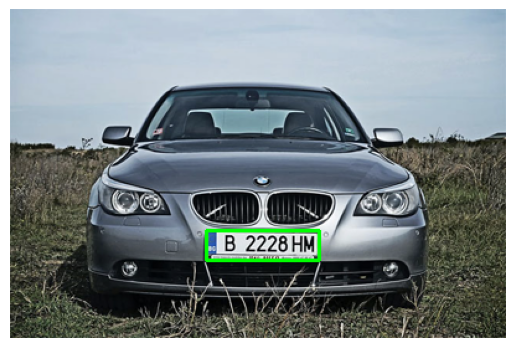

In [ ]:
import cv2
import matplotlib.pyplot as plt

img_path = "datasets/plates/images/val/Cars120.png"
model = YOLO("runs/detect/train/weights/best.pt")

results = model(img_path, conf=0.25, device=0)

img = cv2.imread(img_path)
for box in results[0].boxes.xyxy:
    x1, y1, x2, y2 = map(int, box)
    cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")


STEP 10: OCR (NUMBER PLATE READING)

In [ ]:
import easyocr

reader = easyocr.Reader(['en'], gpu=True)

for box in results[0].boxes.xyxy:
    x1, y1, x2, y2 = map(int, box)
    plate = img[y1:y2, x1:x2]
    text = reader.readtext(plate, detail=0)
    print("Detected Plate:", text)


Detected Plate: ['B2228 HM']


STEP 11: VIDEO TESTING (REAL-WORLD DEMO 🔥)

In [ ]:
cap = cv2.VideoCapture("test_video.mp4")

frame_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1
    results = model(frame, conf=0.25, device="gpu")

    print(f"\nFrame {frame_count}:")

    if results[0].boxes is None:
        print("No number plate detected")
        continue

    for i, box in enumerate(results[0].boxes.xyxy):
        x1, y1, x2, y2 = map(int, box)
        plate = frame[y1:y2, x1:x2]
        text = reader.readtext(plate, detail=0)

        print(f" Plate {i+1} detected")
        print(f"  Bounding Box: {x1,y1,x2,y2}")
        print(f"  OCR Text: {text}")

cap.release()



0: 384x640 4 licences, 10.4ms
Speed: 3.7ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

Frame 1:
 Plate 1 detected
  Bounding Box: (960, 1772, 1222, 1856)
  OCR Text: ['Naib NRU']
 Plate 2 detected
  Bounding Box: (2418, 1570, 2572, 1629)
  OCR Text: ['HVSICSU']
 Plate 3 detected
  Bounding Box: (2401, 1554, 2586, 1637)
  OCR Text: ['MVSITSU']
 Plate 4 detected
  Bounding Box: (944, 1755, 1221, 1869)
  OCR Text: ['Nai3 NRU']

0: 384x640 2 licences, 10.2ms
Speed: 4.0ms preprocess, 10.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

Frame 2:
 Plate 1 detected
  Bounding Box: (950, 1777, 1224, 1857)
  OCR Text: ['NaizNRU']
 Plate 2 detected
  Bounding Box: (2420, 1572, 2566, 1631)
  OCR Text: ['huSITSU']

0: 384x640 3 licences, 10.5ms
Speed: 3.5ms preprocess, 10.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

Frame 3:
 Plate 1 detected
  Bounding Box: (959, 1787, 1202, 1865)
  OCR Text: ['Nai3 NRU']
 Plate


0: 384x640 4 licences, 10.9ms
Speed: 4.6ms preprocess, 10.9ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 licences, 10.7ms
Speed: 3.5ms preprocess, 10.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 licences, 10.1ms
Speed: 3.8ms preprocess, 10.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 licences, 9.7ms
Speed: 4.0ms preprocess, 9.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 licences, 9.6ms
Speed: 3.4ms preprocess, 9.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 licences, 11.0ms
Speed: 3.5ms preprocess, 11.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 licences, 10.0ms
Speed: 3.7ms preprocess, 10.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 licences, 10.0ms
Speed: 4.6ms preprocess, 10.0ms inference, 1.9ms postprocess per image at sha

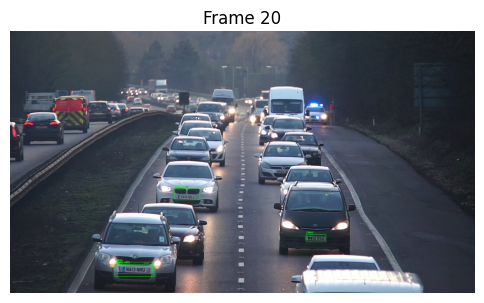


0: 384x640 4 licences, 9.7ms
Speed: 4.0ms preprocess, 9.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 licences, 10.1ms
Speed: 4.8ms preprocess, 10.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 licences, 11.2ms
Speed: 4.2ms preprocess, 11.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 licences, 9.8ms
Speed: 4.9ms preprocess, 9.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 licences, 10.8ms
Speed: 4.3ms preprocess, 10.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 licences, 20.7ms
Speed: 3.5ms preprocess, 20.7ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 licences, 20.9ms
Speed: 3.9ms preprocess, 20.9ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 licences, 27.4ms
Speed: 9.0ms preprocess, 27.4ms inference, 3.8ms postprocess per image at sha

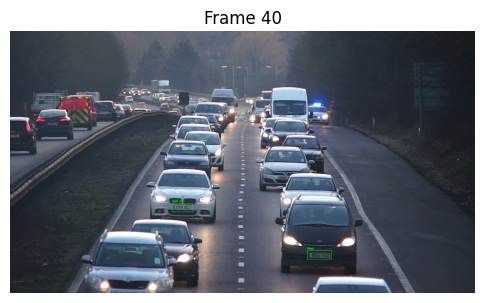


0: 384x640 2 licences, 19.9ms
Speed: 6.5ms preprocess, 19.9ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 licences, 11.9ms
Speed: 6.4ms preprocess, 11.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 licences, 9.9ms
Speed: 3.7ms preprocess, 9.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 licences, 16.4ms
Speed: 7.3ms preprocess, 16.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 licences, 9.8ms
Speed: 3.3ms preprocess, 9.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 licences, 10.4ms
Speed: 3.6ms preprocess, 10.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 licences, 9.3ms
Speed: 4.5ms preprocess, 9.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 licences, 10.3ms
Speed: 9.1ms preprocess, 10.3ms inference, 1.9ms postprocess per image at shape

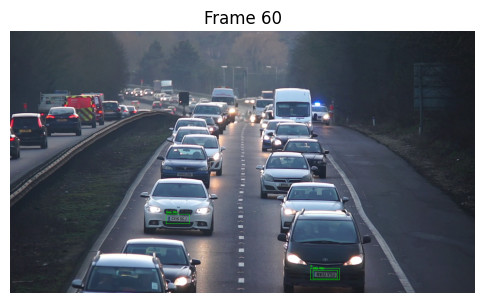


0: 384x640 2 licences, 11.9ms
Speed: 3.5ms preprocess, 11.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 licences, 9.7ms
Speed: 4.4ms preprocess, 9.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 licences, 10.9ms
Speed: 3.6ms preprocess, 10.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 licences, 9.7ms
Speed: 3.1ms preprocess, 9.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 licences, 15.0ms
Speed: 4.9ms preprocess, 15.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 licences, 9.0ms
Speed: 4.2ms preprocess, 9.0ms inference, 3.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 licences, 13.3ms
Speed: 7.4ms preprocess, 13.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 licences, 18.1ms
Speed: 6.9ms preprocess, 18.1ms inference, 1.8ms postprocess per image at shape

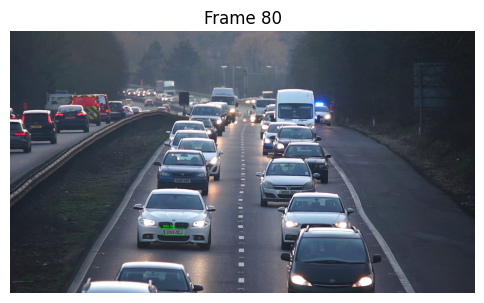


0: 384x640 2 licences, 11.0ms
Speed: 4.1ms preprocess, 11.0ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


In [ ]:
import matplotlib.pyplot as plt
import cv2

cap = cv2.VideoCapture("test_video.mp4")
frame_id = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_id += 1
    results = model(frame, conf=0.25, device="cpu")

    for box in results[0].boxes.xyxy:
        x1, y1, x2, y2 = map(int, box)
        plate = frame[y1:y2, x1:x2]
        text = reader.readtext(plate, detail=0)

        cv2.rectangle(frame, (x1,y1), (x2,y2), (0,255,0), 2)
        if text:
            cv2.putText(frame, text[0], (x1, y1-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)

    # Show every 20th frame
    if frame_id % 20 == 0:
        plt.figure(figsize=(6,4))
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.title(f"Frame {frame_id}")
        plt.axis("off")
        plt.show()

cap.release()


In [ ]:
cap = cv2.VideoCapture("test_video.mp4")

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(
    "output_anpr.mp4",
    fourcc,
    20.0,
    (int(cap.get(3)), int(cap.get(4)))
)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    results = model(frame, conf=0.25, device="cpu")

    for box in results[0].boxes.xyxy:
        x1, y1, x2, y2 = map(int, box)
        plate = frame[y1:y2, x1:x2]
        text = reader.readtext(plate, detail=0)

        cv2.rectangle(frame, (x1,y1), (x2,y2), (0,255,0), 2)
        if text:
            cv2.putText(frame, text[0], (x1, y1-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)

    out.write(frame)

cap.release()
out.release()

print("✅ Output video saved as output_anpr.mp4")



0: 384x640 4 licences, 10.6ms
Speed: 4.5ms preprocess, 10.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 licences, 9.7ms
Speed: 5.5ms preprocess, 9.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 licences, 13.1ms
Speed: 8.5ms preprocess, 13.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 licences, 9.7ms
Speed: 4.7ms preprocess, 9.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 licences, 10.2ms
Speed: 6.2ms preprocess, 10.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 licences, 9.3ms
Speed: 3.6ms preprocess, 9.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 licences, 11.6ms
Speed: 4.3ms preprocess, 11.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 licences, 10.1ms
Speed: 3.5ms preprocess, 10.1ms inference, 1.8ms postprocess per image at shape